# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
print('PyTorch Version:', torch.__version__)
from torchsummary import summary
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

PyTorch Version: 1.0.0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name=os.path.normpath("./Tennis_Linux_NoVis/Tennis.x86_64"))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {:.2f}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.00
Score (max over agents) from episode 2: 0.00
Score (max over agents) from episode 3: 0.00
Score (max over agents) from episode 4: 0.00
Score (max over agents) from episode 5: 0.00


When finished, you can close the environment.

```python
env.close()
```

### 4. Train Deep Deterministic Policy Gradients (DDPG) agents

#### Define the agent training function

In [6]:
def train_ddpg(env, agent_a, agent_b,
               save_model_a_actor, save_model_a_critic, save_model_b_actor, save_model_b_critic,
               n_episodes=5000, eps_start=1.0, eps_end=0.05, eps_decay=1e-5,
               deque_len=100, print_every=100, finish_threshold=0.5):
    """Deep Deterministic Policy Gradients (DDPG)
    
    Params
    ======
        env: environment
        agent_a: DDPG agent (a)
        agent_b: DDPG agent (b)
        save_model_a_actor: actor (a) model filename for saving
        save_model_a_critic: critic (a) model filename for saving
        save_model_b_actor: actor (b) model filename for saving
        save_model_b_critic: critic (b) model filename for saving
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): subtractive factor (per step) for decreasing epsilon
        deque_len (int): length of score deque
        print_every (int): print a new line of scores after such number of episodes
        finish_threshold (float): the training process will finish if the average score is larger than such threshold
    """
    scores_deque = deque(maxlen=deque_len)
    scores_mean = []
    scores_movingmean = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent_a.reset()
        agent_b.reset()
        scores = np.zeros(num_agents)
        step = 0
        while True:
            step += 1
            use_noise = (random.random() <= eps)
            states_a = np.expand_dims(states[0], 0)
            states_b = np.expand_dims(states[1], 0)
            actions_a = agent_a.act(states_a, add_noise=use_noise)
            actions_b = agent_b.act(states_b, add_noise=use_noise)
            actions = np.vstack([actions_a, actions_b])
            eps = max(eps - eps_decay, eps_end)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            next_states_a = np.expand_dims(next_states[0], 0)
            next_states_b = np.expand_dims(next_states[1], 0)
            rewards = env_info.rewards
            dones = env_info.local_done
            agent_a.step(states_a, actions_a, [rewards[0]], next_states_a, [dones[0]])
            agent_b.step(states_b, actions_b, [rewards[1]], next_states_b, [dones[1]])
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
        scores_deque.append(scores)
        scores_mean.append(np.mean(scores))
        scores_movingmean.append(np.mean(scores_deque))
        print('\rEpisode {}:\tMoving average score: {:.4f}\tMean score: {:.3f} (A score: {:.2f}, B score: {:.2f})'.format(
            i_episode, scores_movingmean[-1], scores_mean[-1], scores[0], scores[1]), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}:\tMoving average score: {:.4f}'.format(i_episode, scores_movingmean[-1]))  
        if scores_movingmean[-1] >= finish_threshold:  # save the model
            print('\nEnvironment solved in {:d} episodes!\tMoving average score: {:.4f}'.format(i_episode-deque_len, scores_movingmean[-1]))
            torch.save(agent_a.actor_local.state_dict(), save_model_a_actor)
            torch.save(agent_a.critic_local.state_dict(), save_model_a_critic)
            torch.save(agent_b.actor_local.state_dict(), save_model_b_actor)
            torch.save(agent_b.critic_local.state_dict(), save_model_b_critic)
            break
             
    return scores_mean, scores_movingmean

### 5. DDPG training with Experience Replay

#### 5.1. Train the agent

In [7]:
from agent_ddpg import Agent

agent_a_ddpg = Agent(1, state_size, action_size, random_seed=0, use_per=False)
agent_b_ddpg = Agent(1, state_size, action_size, random_seed=0, use_per=False)

# print the network summary
print('Actor (a) network:')
summary(agent_a_ddpg.actor_local, (state_size,))
print('\nCritic (a) network:')
summary(agent_a_ddpg.critic_local, [(state_size,), (action_size,)])
print('Actor (b) network:')
summary(agent_b_ddpg.actor_local, (state_size,))
print('\nCritic (b) network:')
summary(agent_b_ddpg.critic_local, [(state_size,), (action_size,)])

scores_ddpg_mean, scores_ddpg_movingmean = train_ddpg(env, agent_a_ddpg, agent_b_ddpg,
                                                      'model_actor_a_ddpg.pt', 'model_critic_a_ddpg.pt',
                                                      'model_actor_b_ddpg.pt', 'model_critic_b_ddpg.pt')

Actor (a) network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]          10,000
       BatchNorm1d-2                  [-1, 400]             800
            Linear-3                  [-1, 300]         120,300
            Linear-4                    [-1, 2]             602
Total params: 131,702
Trainable params: 131,702
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.50
Estimated Total Size (MB): 0.51
----------------------------------------------------------------

Critic (a) network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]          10,000
       BatchNorm1d-2                  [-1, 400]             800
 

#### 5.2. Test the trained DDPG agent

In [8]:
# load the weights from the saved checkpoint files
agent_a_ddpg.actor_local.load_state_dict(torch.load('model_actor_a_ddpg.pt'))
agent_a_ddpg.critic_local.load_state_dict(torch.load('model_critic_a_ddpg.pt'))
agent_b_ddpg.actor_local.load_state_dict(torch.load('model_actor_b_ddpg.pt'))
agent_b_ddpg.critic_local.load_state_dict(torch.load('model_critic_b_ddpg.pt'))

# test the trained agent
for i in range(1, 6):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    step = 0
    while True:
        step += 1
        states_a = np.expand_dims(states[0], 0)
        states_b = np.expand_dims(states[1], 0)
        actions_a = agent_a_ddpg.act(states_a, add_noise=False)
        actions_b = agent_b_ddpg.act(states_b, add_noise=False)
        actions = np.vstack([actions_a, actions_b])
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        if np.any(dones):
            break
    print('Scores from episode {}: {:.3f} (A score: {:.2f}, B score: {:.2f})'.format(i, np.mean(scores), scores[0], scores[1]))

Scores from episode 1: 0.045 (A score: 0.10, B score: -0.01)
Scores from episode 2: 2.600 (A score: 2.60, B score: 2.60)
Scores from episode 3: 0.145 (A score: 0.09, B score: 0.20)
Scores from episode 4: 2.600 (A score: 2.60, B score: 2.60)
Scores from episode 5: 0.145 (A score: 0.10, B score: 0.19)


### Comparing the mean score curves

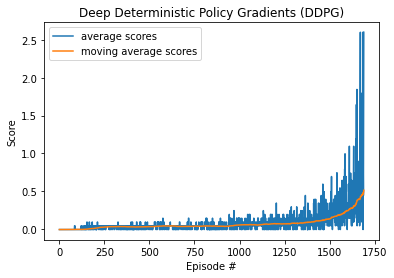

In [9]:
plt.figure()
plt.plot(np.arange(1, len(scores_ddpg_mean)+1), scores_ddpg_mean,
         label='average scores')
plt.plot(np.arange(1, len(scores_ddpg_movingmean)+1), scores_ddpg_movingmean,
         label='moving average scores')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Deep Deterministic Policy Gradients (DDPG)')
plt.show()

### Close the environment

In [10]:
env.close()